In [1]:
import warnings

import numpy as np
import timecorr as tc
import seaborn as sns
import os
from matplotlib import pyplot as plt
from matplotlib import gridspec
from scipy.stats import wishart
import hypertools as hyp
from scipy.spatial.distance import cdist

from timecorr.simulate import random_corrmat, ramping_dataset, block_dataset, constant_dataset, random_dataset

%matplotlib inline

LEGEND_SIZE = 12
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
import sys
sys.executable

'/usr/local/opt/python/bin/python3.6'

In [3]:
figdir = '../figs'
if not os.path.isdir(figdir):
    os.mkdir(figdir)

In [4]:
# def random_corrmat(K):
#     x = np.random.randn(K, K)
#     x = x * x.T
#     x /= np.max(np.abs(x))
#     np.fill_diagonal(x, 1.)
#     return x

In [5]:
# def ramping_dataset(K, T):
#     warnings.simplefilter('ignore')
#     def dist(a, b):
#         return cdist(np.atleast_2d(a), np.atleast_2d(b), 'correlation')
    
#     a = tc.mat2vec(random_corrmat(K))
#     b = tc.mat2vec(random_corrmat(K))
#     max_dist = dist(a, b)
#     max_iter = 100
#     for i in np.arange(max_iter):
#         next_b = tc.mat2vec(random_corrmat(K))
#         next_dist = dist(a, next_b)
#         if next_dist > max_dist:
#             b = next_b
#             max_dist = next_dist
    
#     mu = np.linspace(1, 0, T)
    
#     corrs = np.zeros([T, int((K**2 - K)/2 + K)])
#     Y = np.zeros([T, K])
    
#     for t in np.arange(T):
#         corrs[t, :] = mu[t]*a + (1 - mu[t])*b
#         Y[t, :] = np.random.multivariate_normal(mean=np.zeros([K])+.1, cov=tc.vec2mat(corrs[t, :]))
    
#     return Y, corrs

In [6]:
# def dist(a, b):
#     return cdist(np.atleast_2d(a), np.atleast_2d(b), 'correlation')

In [7]:
# def random_dataset(K, T):
#     warnings.simplefilter('ignore')
        
#     corrs = np.zeros([T, int((K**2 - K)/2 + K)])
#     Y = np.zeros([T, K])
    
#     for t in np.arange(T):
#         corrs[t, :] = tc.mat2vec(random_corrmat(K))
#         Y[t, :] = np.random.multivariate_normal(mean=np.zeros([K]), cov=tc.vec2mat(corrs[t, :]))
    
#     return Y, corrs

In [8]:
# def constant_dataset(K, T):
#     warnings.simplefilter('ignore')
    
#     C = random_corrmat(K)
#     corrs = np.tile(tc.mat2vec(C), [T, 1])
    
#     Y = np.random.multivariate_normal(mean=np.zeros([K])+.1, cov=C, size=T)
    
#     return Y, corrs

In [9]:
# B = 5 #number of blocks
# def block_dataset(K, T):
#     warnings.simplefilter('ignore')
#     block_len = np.ceil(T / B)
    
#     corrs = np.zeros([B, int((K**2 - K)/2 + K)])
#     Y = np.zeros([T, K])
    
#     for b in np.arange(B):
#         corrs[b, :] = tc.mat2vec(random_corrmat(K))
#     corrs = np.repeat(corrs, block_len, axis=0)
#     corrs = corrs[:T, :]
    
#     for t in np.arange(T):
#         Y[t, :] = np.random.multivariate_normal(mean=np.zeros([K])+.1, cov=tc.vec2mat(corrs[t, :]))
    
#     return Y, corrs

In [10]:
def identity_compare(obs_corrs=None):
    if obs_corrs is None:
        return 1
    
    return [obs_corrs]

def first_compare(obs_corrs=None):
    if obs_corrs is None:
        return 1
    
    T = obs_corrs.shape[0]
    return [np.tile(obs_corrs[0, :], [T, 1])]

def last_compare(obs_corrs=None):
    if obs_corrs is None:
        return 1
    
    T = obs_corrs.shape[0]
    return [np.tile(obs_corrs[-1, :], [T, 1])]

def ramping_compare(obs_corrs=None):
    if obs_corrs is None:
        return 2
    
    T = obs_corrs.shape[0]
    return [np.tile(obs_corrs[0, :], [T, 1]), np.tile(obs_corrs[-1, :], [T, 1])]

def block_compare(obs_corrs=None):
    if obs_corrs is None:
        return B
    
    T = obs_corrs.shape[0]
    block_len = np.ceil(T / B)
    
    bs = np.repeat(np.atleast_2d(np.arange(B)).T, block_len, axis=0)
    bs = bs[:T, :]
    
    obs_parsed = []
    for b in np.arange(B):
        i = np.where(bs == b)[0][0]
        obs_parsed.append(np.tile(obs_corrs[i, :], [T, 1]))
    return obs_parsed


In [11]:
def plot_ribbon(ts, xs, color='k', ribbon_alpha=0.2, ax=None, xlab=None, ylab=None):
    mean = np.mean(xs, axis=0)
    ci = 1.96 * np.divide(np.std(xs, axis=0), np.sqrt(xs.shape[0]))
    
    if ax == None:
        ax = plt.gca()
    plt.sca(ax)
    
    h1 = ax.fill_between(ts, mean - ci, mean + ci, color=color, alpha=ribbon_alpha)
    h2 = ax.plot(ts, mean, color=color)
    
    if not (xlab == None):
        plt.xlabel(xlab)
    
    if not (ylab == None):
        plt.ylabel(ylab)
    
    return h1, h2

In [12]:
#look into this: https://matplotlib.org/users/gridspec.html
def make_subplots(N, K, legend, corrmap):
    C = 3
    width = C*(N + int(legend)) + int(corrmap)
    height = C
    
    fig = plt.gcf()
    fig.set_size_inches(w=C*(N+int(legend)+int(corrmap)), h=height)
    gs = gridspec.GridSpec(nrows=height, ncols=width, wspace=0.0)
    gs.update(left=0, right=1, wspace=0.1)
    
    #fig.tight_layout(pad=0, h_pad=None, w_pad=None, rect=None)
    
    axes = []
    for n in np.arange(N + int(legend)):
        a = ()
        axes.append(plt.subplot(gs[:, (C * n):((C * (n + 1) -1))]))
    
    if corrmap:
        n = N + int(legend)
        sub_gs = gridspec.GridSpecFromSubplotSpec(K, 1, subplot_spec=gs[:, (C * n):((C * (n + 1) -1))], hspace=0.1)
        for k in np.arange(K):
            axes.append(plt.subplot(sub_gs[k, :]))
    return fig, axes

In [13]:
def format_subplots(ax, N):
    #timeseries plots
    xlim = [np.inf, -np.inf]
    ylim = [np.inf, -np.inf]
    
    for n in np.arange(N):
        next_xlim = ax[n].get_xlim()
        next_ylim = ax[n].get_ylim()
        
        if next_xlim[0] < xlim[0]:
            xlim[0] = next_xlim[0]
        
        if next_ylim[0] < ylim[0]:
            ylim[0] = next_ylim[0]
        
        if next_xlim[1] > xlim[1]:
            xlim[1] = next_xlim[1]
        
        if next_ylim[1] > ylim[1]:
            ylim[1] = next_ylim[1]
    
    for n in np.arange(N):
        ax[n].set_xlim(xlim)
        ax[n].set_ylim(ylim)
        if n > 0:
            ax[n].set_yticklabels([])
    
    return xlim, ylim

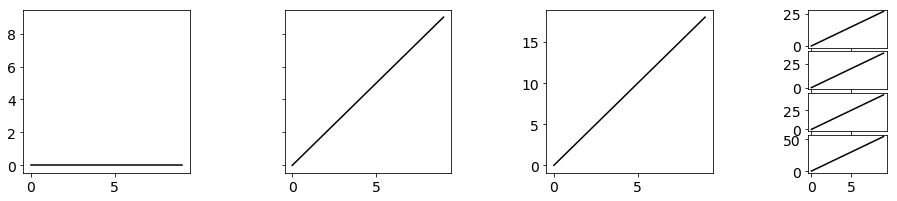

In [14]:
N = 2
K = 4
fig, ax = make_subplots(N, K, True, True);
for i, a in enumerate(ax):
    a.plot(np.arange(10), i*np.arange(10), 'k')
format_subplots(ax, N);

In [15]:
def recovery_test_multi(K, T, N, kernels, datagen=ramping_dataset, testfuns=[identity_compare], legend=True, corrmap=False, titles=None, xlab='Time', ylab='Correlation'):
    def add_to_axis(ts, corrs, colors, ax):        
        for i in np.arange(len(kernels)):
            plot_ribbon(ts, corrs[i], color=colors[i], ax=ax)
        ax.set(xlim=[0, T-1])
        if not (xlab == None):
            ax.set(xlabel=xlab)
    
    def recovery_corrs(truth, guess):
        if type(truth) is list:
            c_sum = np.zeros()
        return np.diag(1 - cdist(truth[:, K:], guess[:, K:], 'correlation'))
    
    J = 0
    for t in testfuns:
        J += t()
    
    corr_tests = []
    for i in np.arange(J):
        x = []
        for j in np.arange(len(kernels)):
            x.append(np.zeros([N, T]))
        corr_tests.append(x)
    
    if corrmap:
        recovered_tcorr_mat = []
        for k in kernels:
            recovered_tcorr_mat.append(np.zeros([T, T]))
    
    for n in np.arange(N):
        next_Y, next_corrs = datagen(K, T)
        for i, k in enumerate(kernels):
            recovered_corrs = tc.timecorr(next_Y, weights_function=k['weights'], weights_params=k['params'])
            j = 0
            for t in np.arange(len(testfuns)):
                obs_parsed = testfuns[j](next_corrs)
                for next_obs in obs_parsed:
                    corr_tests[j][i][n, :] = recovery_corrs(next_obs, recovered_corrs)
                    j += 1
            if corrmap:
                recovered_tcorr_mat[i] = recovered_tcorr_mat[i] + tc.helpers.r2z(1 - cdist(next_corrs, recovered_corrs, 'correlation'))
    if corrmap:
        for i in np.arange(len(kernels)):
            recovered_tcorr_mat[i] = tc.helpers.z2r(np.divide(recovered_tcorr_mat[i], N))
    
    n = 0
    if legend:
        n += 1
    if corrmap:
        n += len(kernels)
    
    colors = sns.color_palette(n_colors=len(kernels))
    #fig, ax = plt.subplots(nrows=1, ncols=len(testfuns)+n, sharey=True, sharex=False)
    fig, ax = make_subplots(J, len(kernels), legend, corrmap)
    
    #fig.set_size_inches(10, 2)
    
    ts = np.arange(T)
    for i in np.arange(J):
        add_to_axis(ts, corr_tests[i], colors, ax[i])

    if not (ylab == None):
        ax[0].set(ylabel=ylab)    
    
    if legend:
        hs = []
        for i in np.arange(len(kernels)):
            hs.append(ax[-n].plot(ts, np.ones_like(ts), color=colors[i]))
        ax[-n].legend(list(map(lambda x: x['name'], kernels)), loc='center', frameon=False)
        ax[-n].axis('off')
        for h in hs:
            h[0].set_visible(False)
    
    xlim, ylim = format_subplots(ax, J)
    
    if corrmap:                    
        for i in np.arange(len(kernels)):
            sns.heatmap(recovered_tcorr_mat[i], ax=ax[-n+i+1], vmin=ylim[0], vmax=ylim[1], cbar=False)
            ax[-n+i+1].set_xticks([])
            ax[-n+i+1].set_yticks([])
    
    if not (titles == None):
        if not (type(titles) == list):
            titles = [titles]*(len(ax)-n)
        for i, a in enumerate(ax):
            if i > len(ax) - (n + 1):
                break
            a.set_title(titles[i])
    
    

In [21]:
width = 10
delta = {'name': '$\delta$', 'weights': tc.eye_weights, 'params': tc.eye_params}
gaussian = {'name': 'Gaussian', 'weights': tc.gaussian_weights, 'params': {'var': width}}
laplace = {'name': 'Laplace', 'weights': tc.laplace_weights, 'params': {'scale': width}}
mexican_hat = {'name': 'Mexican hat', 'weights': tc.mexican_hat_weights, 'params': {'sigma': width}}
kernels = [delta, gaussian, laplace, mexican_hat]


K = 50
T = 300
N = 10

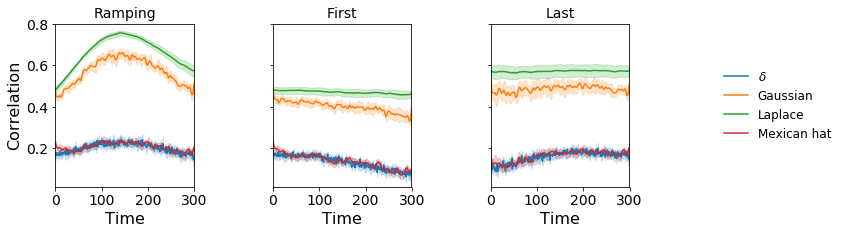

In [22]:
recovery_test_multi(K, T, N, kernels, datagen=ramping_dataset, testfuns=[identity_compare, ramping_compare], titles=['Ramping', 'First', 'Last'])
plt.gcf().savefig(os.path.join(figdir, f'ramping_recovery_{width}.pdf'), bbox_inches='tight')

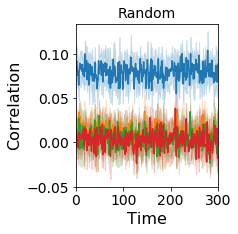

In [18]:
recovery_test_multi(K, T, N, kernels, datagen=random_dataset, testfuns=[identity_compare], titles=['Random'], legend=False)
plt.gcf().savefig(os.path.join(figdir, f'random_recovery_{width}.pdf'), bbox_inches='tight')

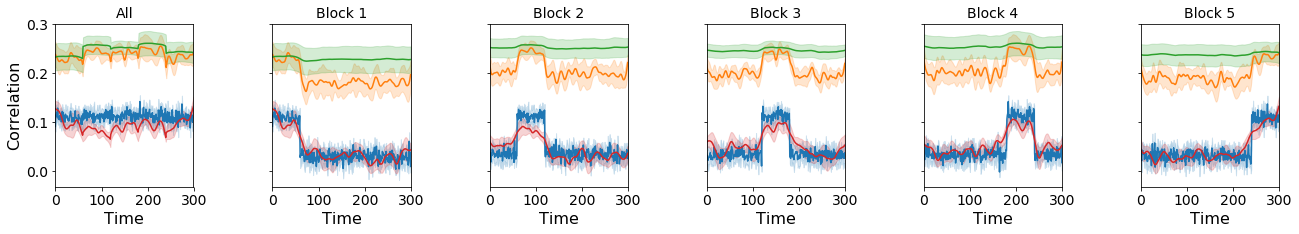

In [19]:
B = 5
titles = ['All']
titles.extend(list(map(lambda b: f'Block {b+1}', np.arange(B))))
recovery_test_multi(K, T, N, kernels, datagen=block_dataset, testfuns=[identity_compare, block_compare], titles=titles, legend=False)
plt.gcf().savefig(os.path.join(figdir, f'block_recovery_{width}.pdf'), bbox_inches='tight')

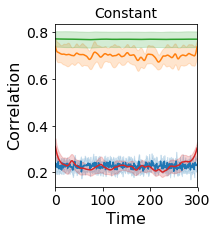

In [20]:
recovery_test_multi(K, T, N, kernels, datagen=constant_dataset, testfuns=[identity_compare], titles=['Constant'], legend=False)
plt.gcf().savefig(os.path.join(figdir, f'constant_recovery_{width}.pdf'), bbox_inches='tight')